In [1]:
#!/usr/bin/env/python -W ignore::DeprecationWarning
import pandas as pd
import numpy as np

#Data Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.model_selection import  GridSearchCV

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Goals and gotchas:
### We have several numeric fields, like Age, Salary, and Tenure.
### We will be able to balance these fields to some extent, through quantile binning, when necessary.
### However, the country field is unbalanced and will need subsampling, as we will see.

# Goal:
## Choose the features that are strong indicators of churn, based on the RandomForest ensemble method. 

In [2]:
data = pd.read_csv('data/Churn_Modelling.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#In classification, we should have nearly the same number of classes.
# Here, our classes are those who stay with the bank (0) and those who leave, or churn (1)
# Let's see how many of each we have:
print("The number of people who left: {}. The number of people who stayed: {}"\
      .format(len(data[data['Exited']== 1]), 
              len(data[data['Exited']== 0])))

The number of people who left: 2037. The number of people who stayed: 7963


# Based on class, we have an unbalanced data set, so we can either sub-sample or use AUROC instread of accuracy
### Unless we are using an ANN, in which case the inbalance doesn't matter. However, we will see if this improves later.

In [5]:
model_data = data[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [7]:
geo_counts = pd.Series(model_data['Geography']).value_counts()

In [8]:
geo_counts

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

## The dataset is biased towards France, since France has twice as many samples as the other two countries. Lets subsample this.

In [10]:
# Here we are taking a subsample of France
france_sampled = model_data[model_data['Geography'] == 'France'].sample(frac=.50)

In [11]:
len(france_sampled)

2507

In [12]:
not_france = model_data[(model_data['Geography'] == 'Germany') | ( model_data['Geography'] == 'Spain')]

In [13]:
country_balanced = pd.concat([france_sampled,not_france])

In [14]:
#After resampling, let's see how class balance changed
# Here, our classes are those who stay with the bank (0) and those who leave, or churn (1)
# Let's see how many of each we have:
print("The number of people who left: {}. The number of people who stayed: {}"\
      .format(len(country_balanced[country_balanced['Exited']== 1]), 
              len(country_balanced[country_balanced['Exited']== 0])))

The number of people who left: 1661. The number of people who stayed: 5832


# Distribution of classes does look better, but we better stick to AUROC for non-network algorithms.
## Let's look at the features.

In [15]:
X = country_balanced [['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']].values
y = country_balanced ['Exited'].values

In [16]:
# Intitiate our label encoder for the categorical variables

labelencoder_X1 = LabelEncoder()
X[:, 1] = labelencoder_X1.fit_transform(X[:, 1])

In [17]:
labelencoder_X2 = LabelEncoder()
X[:, 2] = labelencoder_X2.fit_transform(X[:, 2])

In [18]:
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()

In [19]:
# Drop one country column
X = X[:,1:]

In [20]:
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()

In [21]:
# Drop one country column
X = X[:,1:]

In [22]:
params = {
    'n_estimators': 10000,
    'criterion': 'gini',#default
    'random_state':0,
    'n_jobs':-1
}

clf = RandomForestClassifier(**params)

clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
names = country_balanced.columns[0:10]

In [24]:
feature_importances = (sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), names),
                          reverse=True))

In [25]:
importances = [x[0] for x in feature_importances]

In [26]:
features = [x[1] for x in feature_importances]

Text(0.5, 1.0, 'Feature Importance')

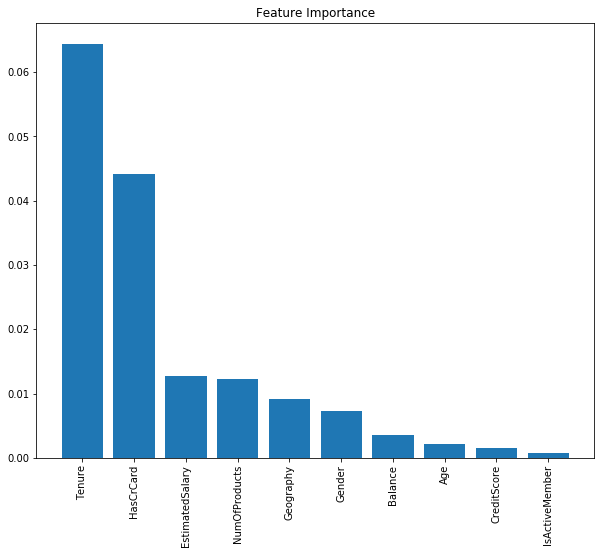

In [27]:
fig = plt.figure(figsize=(10,8))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.title('Feature Importance')

In [28]:
tenure_left= pd.Series(country_balanced['Tenure'][country_balanced['Exited'] == 1]).value_counts()

In [29]:
tenure_left_df = pd.DataFrame(tenure_left)

In [30]:
tenure_left_df['x'] = tenure_left.index

Text(0.5, 1.0, 'Tenure (in years) of churned customers')

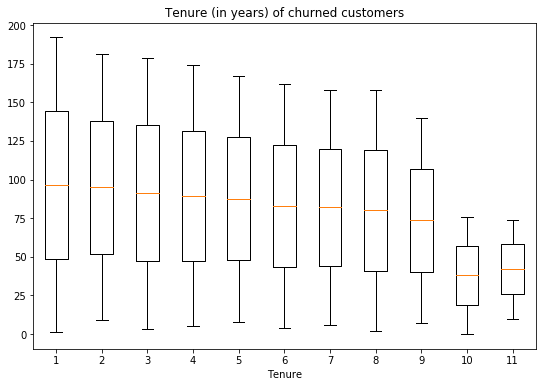

In [31]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(tenure_left_df)
plt.xlabel("Tenure")
plt.title("Tenure (in years) of churned customers")

In [32]:
# Clear trend above
card_left= pd.Series(country_balanced['HasCrCard'][country_balanced['Exited'] == 1]  ).value_counts()
card_left_df = pd.DataFrame(card_left)
card_left_df['x'] = card_left.index

Text(0.5, 1.0, "Number of churned customers who have cards vs those who don't")

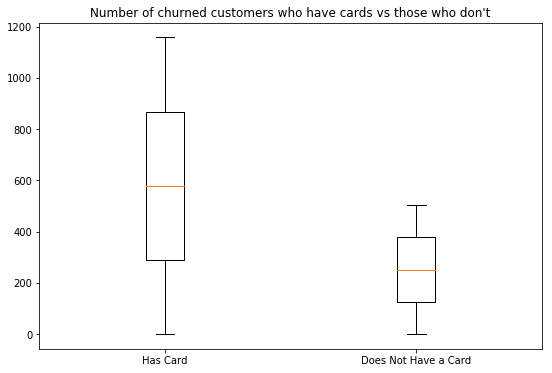

In [33]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(card_left_df)

locs, labels = plt.xticks()   
plt.xticks(locs, ['Has Card', "Does Not Have a Card"])

plt.title("Number of churned customers who have cards vs those who don't")

In [34]:
#Those who do not have a credit card with the bank are nearly twice as likely to leave!

In [35]:
np.min(country_balanced['EstimatedSalary'])

11.58

In [36]:
np.max(country_balanced['EstimatedSalary'])

199992.48

In [41]:
#The data is skewed to the right 
np.mean(country_balanced['EstimatedSalary'])

100436.15292940062

In [42]:
fifteen_perc = np.quantile(country_balanced['EstimatedSalary'], .15)
thirty_perc = np.quantile(country_balanced['EstimatedSalary'], .30)
fourfive_perc = np.quantile(country_balanced['EstimatedSalary'], .45)
sixty_perc = np.quantile(country_balanced['EstimatedSalary'], .60)
sevenfive_perc = np.quantile(country_balanced['EstimatedSalary'], .75)
ninety = np.quantile(country_balanced['EstimatedSalary'], .90)

In [43]:
def assign_quantile(salary):
    
    if salary <= fifteen_perc:
        return "first"
    
    elif salary > fifteen_perc and salary <= thirty_perc:
        return "second"
    
    elif salary > thirty_perc and salary <= fourfive_perc:
        return "third"
    
    elif salary > fourfive_perc and salary <= sixty_perc:
        return "fourth"
    
    elif salary > sixty_perc and salary <= sevenfive_perc:
        return "fifth"
    
    elif salary > sevenfive_perc and salary <= ninety:
        return "sixth"
    
    elif salary > ninety:
        return "seventh"
    

In [44]:
quantiles = [assign_quantile(x) for x in country_balanced['EstimatedSalary']]

In [46]:
country_balanced['salary_quantiles'] = quantiles

In [53]:
salary_left= pd.Series(country_balanced['salary_quantiles'][country_balanced['Exited'] == 1]  ).value_counts()
salary_left_df = pd.DataFrame(salary_left)
salary_left_df['x'] = [6,1,4,5,2,3,7]

In [54]:
salary_left_df

,salary_quantiles,x
sixth,272,6
first,250,1
fourth,247,4
fifth,247,5
second,247,2
third,240,3
seventh,158,7


In [55]:
fifteen_perc,thirty_perc ,fourfive_perc ,sixty_perc,sevenfive_perc,ninety 

(30520.742, 60991.22200000001, 90854.87, 119925.402, 149697.78, 179975.854)

In [61]:
thirty_perc ,fourfive_perc

(60991.22200000001, 90854.87)

Text(0.5, 1.0, 'Customer Churn by Salary Quantile')

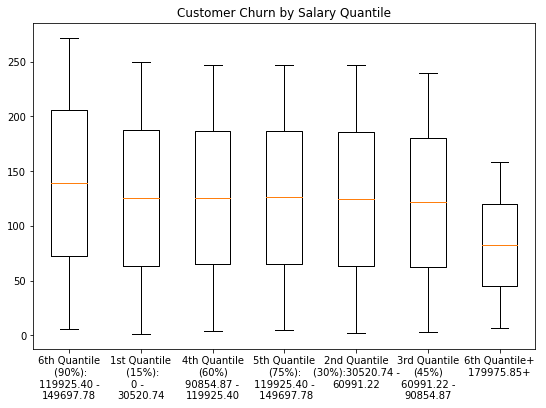

In [71]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(salary_left_df)

locs, labels = plt.xticks()   
plt.xticks(locs, ['6th Quantile\n (90%):\n119925.40 -\n149697.78', '1st Quantile\n (15%):\n0 -  \n30520.74', '4th Quantile\n(60%)\n90854.87 -\n119925.40', "5th Quantile\n(75%):\n119925.40 -\n 149697.78", "2nd Quantile\n(30%):30520.74 -\n60991.22", "3rd Quantile\n(45%)\n60991.22 -\n90854.87", "6th Quantile+\n179975.85​+"])


plt.title("Customer Churn by Salary Quantile")

In [72]:
#The highest income group is least likely to leave, while the second highest, 6th quantile is most likely.
# 1st, 4th, 5th, 2nd and 3rd are all about equally as likely to leave

In [76]:
salary_stayed= pd.Series(country_balanced['salary_quantiles'][country_balanced['Exited'] == 0]  ).value_counts()
salary_stayed_df = pd.DataFrame(salary_stayed)
salary_stayed_df['x'] = [3,2,4,5,1,6,7]

In [77]:
salary_stayed_df

,salary_quantiles,x
third,884,3
second,877,2
fourth,877,4
fifth,877,5
first,874,1
sixth,851,6
seventh,592,7


Text(0.5, 1.0, 'Customer Retained by Salary Quantile')

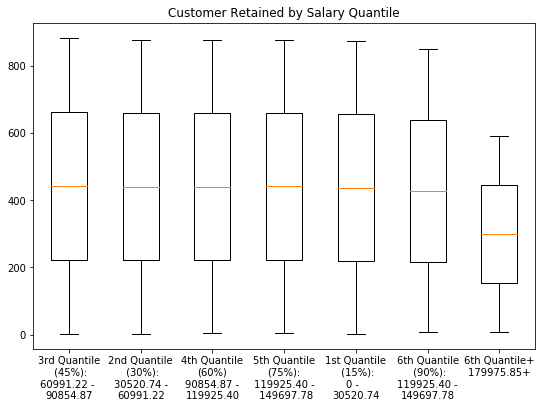

In [81]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(salary_stayed_df)

locs, labels = plt.xticks()   
plt.xticks(locs, ['3rd Quantile\n (45%):\n60991.22 - \n90854.87', '2nd Quantile\n (30%):\n30520.74 -\n60991.22', '4th Quantile\n(60%)\n90854.87 -\n119925.40', "5th Quantile\n(75%):\n119925.40 -\n 149697.78", "1st Quantile\n (15%):\n0 -  \n30520.74", "6th Quantile\n (90%):\n119925.40 -\n149697.78", "6th Quantile+\n179975.85​+"])


plt.title("Customer Retained by Salary Quantile")

In [82]:
country_balanced['Age'].min(), country_balanced['Age'].max(), country_balanced['Age'].mean()

(18, 88, 39.016148405178164)

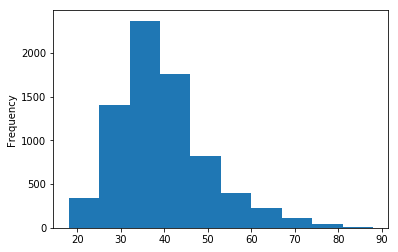

In [83]:
# Age is a bit left-skewed
country_balanced['Age'].plot(kind='hist')

In [84]:
fifteen_perc = np.quantile(country_balanced['Age'], .15)
thirty_perc = np.quantile(country_balanced['Age'], .30)
fourfive_perc = np.quantile(country_balanced['Age'], .45)
sixty_perc = np.quantile(country_balanced['Age'], .60)
sevenfive_perc = np.quantile(country_balanced['Age'], .75)
ninety = np.quantile(country_balanced['Age'], .90)

In [85]:
# 90% under 53!
ninety

53.0

In [86]:
quantiles = [assign_quantile(x) for x in country_balanced['Age']]
country_balanced['age_quantiles'] = quantiles

In [91]:
aged_stayed= pd.Series(country_balanced['age_quantiles'][country_balanced['Exited'] == 0]  ).value_counts()
aged_stayed_df = pd.DataFrame(aged_stayed)
aged_stayed_df['x'] = [4,1,2,3,5,6, 7]

In [92]:
aged_stayed_df

,age_quantiles,x
fourth,1116,4
first,1114,1
second,1066,2
third,902,3
fifth,693,5
sixth,522,6
seventh,419,7


Text(0.5, 1.0, 'Customer Remaining by Age  Quantile (.15 - .90)')

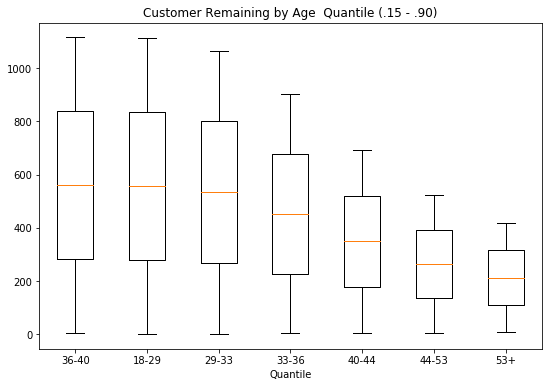

In [93]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(aged_stayed_df)

locs, labels = plt.xticks()   
plt.xticks(locs, ['36-40', '18-29', '29-33', '33-36','40-44', '44-53', '53+'])
plt.xlabel("Quantile")

plt.title("Customer Remaining by Age  Quantile (.15 - .90)")

In [94]:
# Could it be that wealthy older folks are the ones leaving?

In [102]:
aged_left= pd.Series(country_balanced['age_quantiles'][country_balanced['Exited'] == 1]  ).value_counts()
aged_left_df = pd.DataFrame(aged_left)
aged_left_df['x'] = [6,7,5,4,3,1,2]

In [103]:
aged_left_df

,age_quantiles,x
sixth,535,6
seventh,316,7
fifth,243,5
fourth,235,4
third,121,3
first,108,1
second,103,2


Text(0.5, 1.0, 'Customer Churn by Age  Quantile (.15 - .90)')

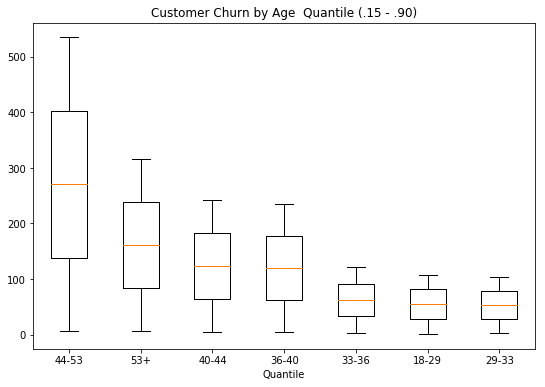

In [104]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(aged_left_df)

locs, labels = plt.xticks()   
plt.xticks(locs, ['44-53', '53+', '40-44', '36-40','33-36', '18-29', '29-33'])
plt.xlabel("Quantile")

plt.title("Customer Churn by Age  Quantile (.15 - .90)")

In [164]:
prod_counts_stayed =  pd.Series(country_balanced['NumOfProducts'][country_balanced['Exited'] == 0]  ).value_counts()
prod_counts_stayed_df = pd.DataFrame(prod_counts_stayed)
prod_counts_stayed_df['x'] = prod_counts_stayed.index

In [166]:
prod_counts_stayed_df

,NumOfProducts,x
2,3111,2
1,2685,1
3,36,3


Text(0.5, 1.0, 'Customer Remaining by Number of Products')

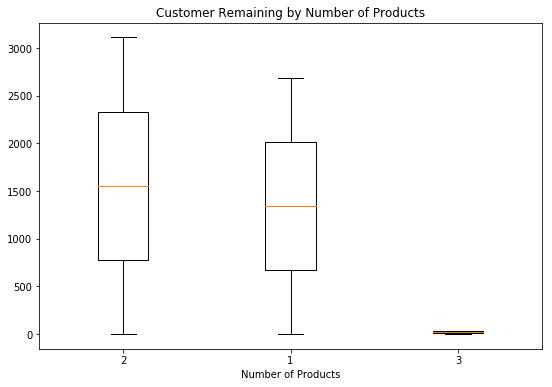

In [169]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(prod_counts_stayed_df)

locs, labels = plt.xticks()   
plt.xticks(locs,prod_counts_stayed.index)
plt.xlabel('Number of Products')

plt.title("Customer Remaining by Number of Products")

In [170]:
prod_counts_left =  pd.Series(country_balanced['NumOfProducts'][country_balanced['Exited'] == 1]  ).value_counts()
prod_counts_left_df = pd.DataFrame(prod_counts_left)
prod_counts_left_df['x'] = prod_counts_left.index

Text(0.5, 1.0, 'Customer Churn by Number of Products')

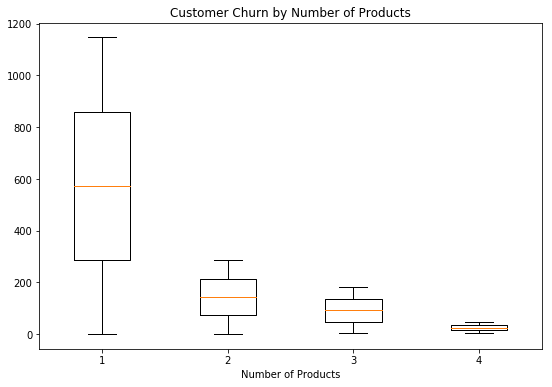

In [172]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(prod_counts_left_df)

locs, labels = plt.xticks()   
plt.xticks(locs,prod_counts_left.index)
plt.xlabel('Number of Products')

plt.title("Customer Churn by Number of Products")

In [ ]:
# It looks like there is a correlation of number of products and a customer remaining;
# Those with few products seem more likely to leave.

In [113]:
geo_counts_stayed =  pd.Series(country_balanced['Geography'][country_balanced['Exited'] == 0]  ).value_counts()
geo_stayed_df = pd.DataFrame(geo_counts_stayed)
geo_stayed_df['x'] =[0,1,2]

In [120]:
geo_counts_stayed 

France     2073
Spain      2064
Germany    1695
Name: Geography, dtype: int64

In [114]:
geo_stayed_df

,Geography,x
France,2073,0
Spain,2064,1
Germany,1695,2


Text(0.5, 1.0, 'Customer Remaining by Country')

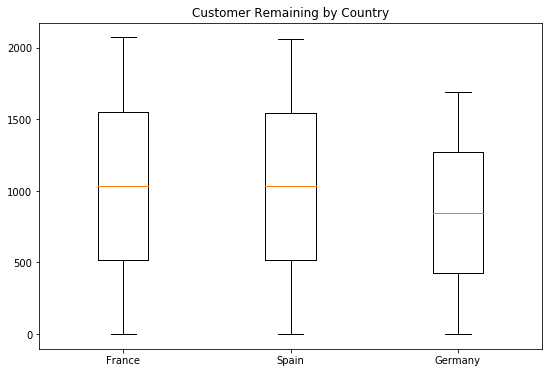

In [115]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(geo_stayed_df)

locs, labels = plt.xticks()   
plt.xticks(locs,geo_counts_stayed.index)

plt.title("Customer Remaining by Country")

In [112]:
# German customers seem to be more loyal, with France slighlty more loyal than Spain.

In [131]:
geo_counts_left =  pd.Series(country_balanced['Geography'][country_balanced['Exited'] == 1]  ).value_counts()
geo_left_df = pd.DataFrame(geo_counts_left)
geo_left_df['x'] =[0,1,2]

In [132]:
geo_counts_left

Germany    814
France     434
Spain      413
Name: Geography, dtype: int64

In [133]:
geo_left_df

,Geography,x
Germany,814,0
France,434,1
Spain,413,2


Text(0.5, 1.0, 'Customer Churn by Country')

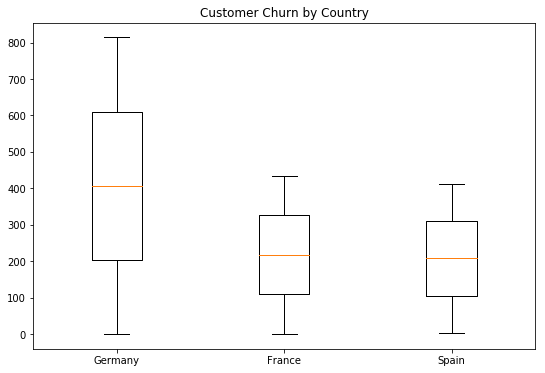

In [135]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(geo_left_df)

locs, labels = plt.xticks()   
plt.xticks(locs,geo_counts_left.index)

plt.title("Customer Churn by Country")

In [139]:
gender_counts = pd.Series(country_balanced['Gender']).value_counts()

In [144]:
gender_counts

Male      4061
Female    3432
Name: Gender, dtype: int64

In [145]:
gender_counts2 = pd.Series(country_balanced['Gender'][country_balanced['Exited'] == 0]).value_counts()

In [146]:
# Looks like males are more likely to stay, though slightly more males than females in 
gender_counts2

Male      3323
Female    2509
Name: Gender, dtype: int64

In [157]:
print('There are about {}% more males than females in the data.'.format(1  - 3432/4061))

There are about 0.15488795863087912% more males than females in the data.


In [153]:
print('With a primitive population adjustment, the trend still holds; {} males vs {} females. '.format(3323 - 3323*.155, 2509))

With a primitive population adjustment, the trend still holds; 2807.935 males vs 2509 females. 


In [158]:
gender_counts3 = pd.Series(country_balanced['Gender'][country_balanced['Exited'] == 1]).value_counts()

In [160]:
print('Of those who churned, {} were female, while (adjusting for population) {} were male'.format(923, 738-738*.155))

Of those who churned, 923 were female, while (adjusting for population) 623.61 were male


In [ ]:
# Gender doesn't appear to be a strong indicator, but we will use it. 
#So,  we will select Tenure, HasCrdCard, NumProducts, Income, and Numproducts, gender, and geography.
# However, we will choose the binned versions we have defined, when applicable, like for age and salary. 

In [173]:
all_churned = country_balanced[country_balanced['Exited'] == 1]

<Figure size 720x576 with 0 Axes>

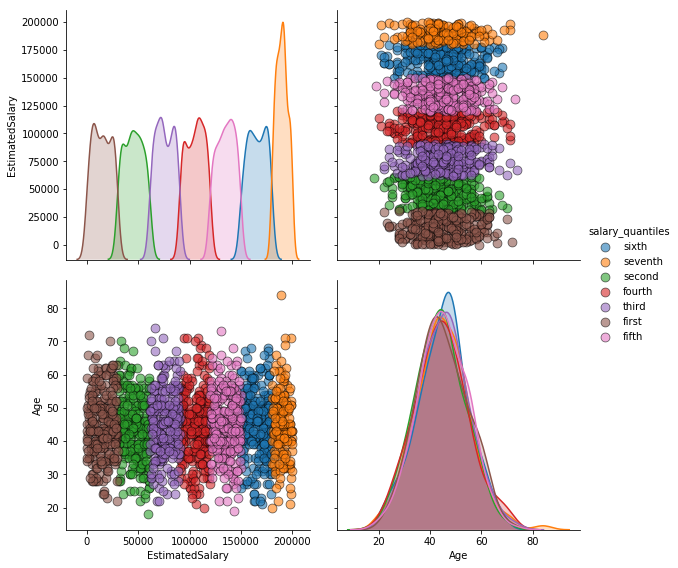

In [191]:
# Before we save the results here for modeling, How about looking at age and income. We saw surprising correlations
# here. So, looking at age and income together
import seaborn as sns

plt.figure(figsize=(10,8))
sns.pairplot(all_churned[['EstimatedSalary','Age', 'salary_quantiles']], 
             'salary_quantiles' ,
            diag_kind='kde',
            plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'},
            height=4)

In [185]:
# Looking at the visual bottom-right, above, it does look like older, high-income customers are the most likely to churn.
# However, the most likely to churn, the highest 10% of income is not necessarily older.
# Here, seventh quartile isn't a quartile per se, but represents the 90%+ quartile. In other words, 6th quartile+

In [186]:
all_stayed = country_balanced[country_balanced['Exited'] == 0]

<Figure size 720x576 with 0 Axes>

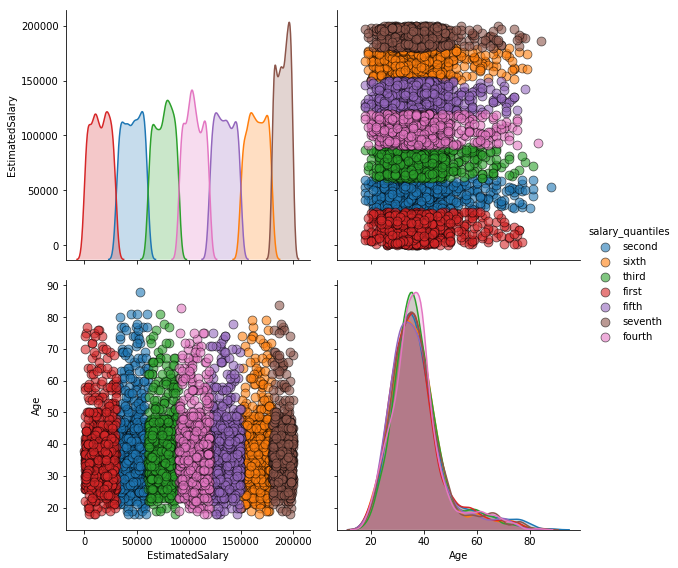

In [195]:
plt.figure(figsize=(10,8))
sns.pairplot(all_stayed[['EstimatedSalary','Age', 'salary_quantiles']], 
             'salary_quantiles' ,
             diag_kind='kde',
            plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'},
            height=4)

## Those who stay tend to be younger and richer. This is surprising.
### The takeway is that those around 50 - 62 and in the top  75-90% of income are most likely to leave,
### while those in the top 10% of income and under the age of 50 (really around 37) are more likely to stay. 

In [194]:
country_balanced[['Tenure','Gender','Geography','salary_quantiles', 'age_quantiles','NumOfProducts', 'HasCrCard', 'Exited']].to_csv('data/customer_churn_balanced.csv', index=False)